In [1]:
# load libraries, set seed
library(tidyverse)
library(tidymodels)
library(GGally)
set.seed(3)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# load and read basketball data
cbb <- read_csv("https://raw.githubusercontent.com/naw333/College-Basketball-Data-Science/main/cbb.csv") |>
        mutate(POSTSEASON = as_factor(POSTSEASON)) |>
        mutate(PERC= W/G) 
#cbb

# split data into training and testing sets
cbb_split <- initial_split(cbb, 0.75, POSTSEASON)
cbb_train <- training(cbb_split) 
cbb_test <- testing(cbb_split)

Rows: 3523 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): TEAM, CONF, POSTSEASON, SEED
dbl (20): G, W, ADJOE, ADJDE, BARTHAG, EFG_O, EFG_D, TOR, TORD, ORB, DRB, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


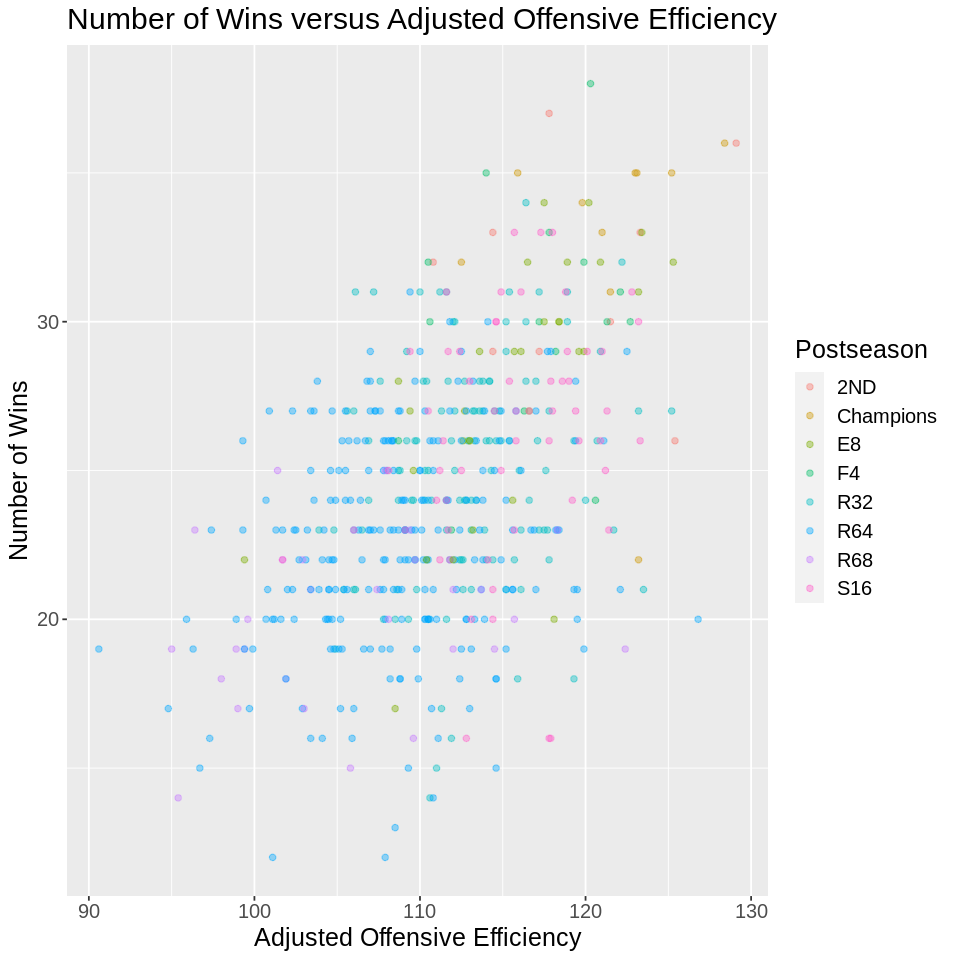

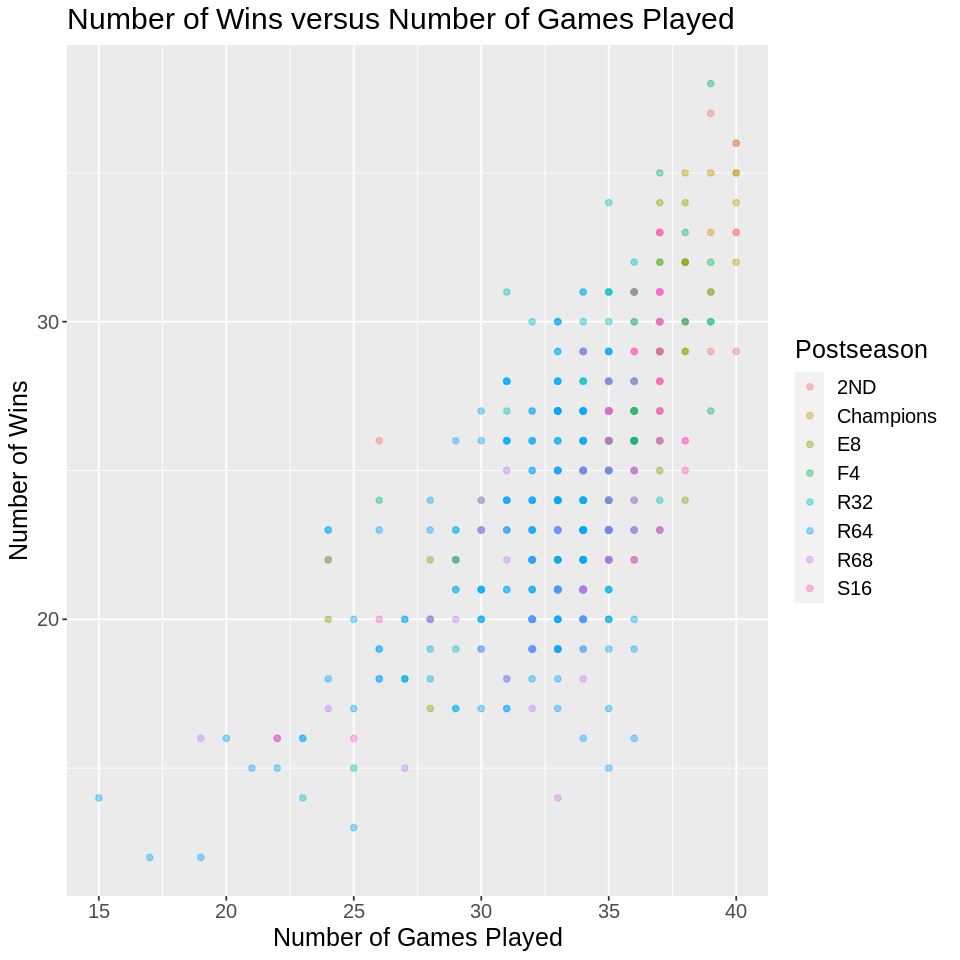

In [3]:
# preliminary analysis:

options(repr.plot.width = 8, repr.plot.height = 8)

# ggpairs plot comparing all variables
pairs_plot <- cbb_train |>
            filter(POSTSEASON != "N/A") |>
            select(G, W, ADJOE, ADJDE, TOR, `3P_O`) |>
            ggpairs(cardinality_threshold = NULL)
#pairs_plot

# W vs. ADJOE
cbb_plot1 <- cbb_train |>
            filter(POSTSEASON != "N/A") |>
            ggplot(aes(x = ADJOE, y = W, color = POSTSEASON)) +
                geom_point(alpha = 0.4) +
                labs(x = "Adjusted Offensive Efficiency",
                    y = "Number of Wins",
                    color = "Postseason") +
                ggtitle("Number of Wins versus Adjusted Offensive Efficiency") +
                theme(text = element_text(size = 15))
cbb_plot1

# W vs. G
cbb_plot2 <- cbb_train |>
            filter(POSTSEASON != "N/A") |>
            ggplot(aes(x = G, y = W, color = POSTSEASON)) +
                geom_point(alpha = 0.4) +
                labs(x = "Number of Games Played",
                    y = "Number of Wins",
                    color = "Postseason") +
                ggtitle("Number of Wins versus Number of Games Played") +
                theme(text = element_text(size = 15))
cbb_plot2

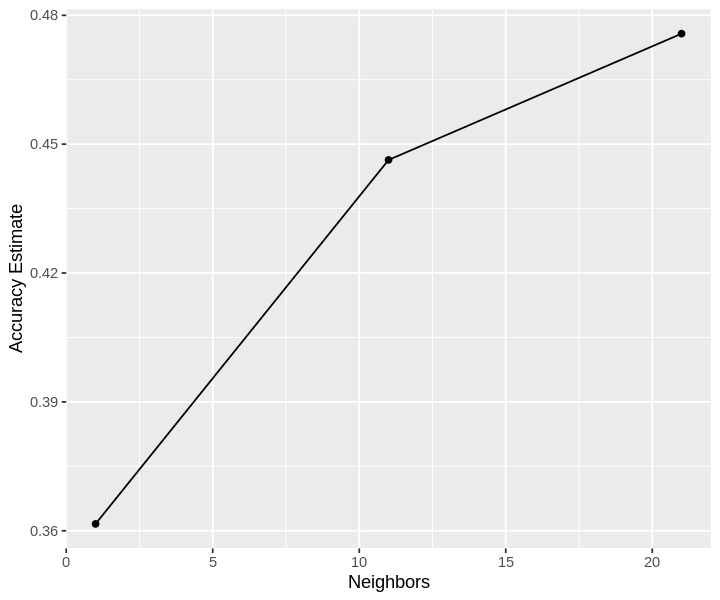

In [4]:
options(repr.plot.height = 5, repr.plot.width = 6)
basket_recipe <- recipe(POSTSEASON ~ PERC + ADJOE + ADJDE + EFG_O + TOR + TORD + ORB + FTR + `2P_D` + `3P_D` + ADJ_T, data = cbb_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors()) 

basket_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
          set_engine("kknn") |>
          set_mode("classification")
    
basket_vfold <- vfold_cv(cbb_train, v = 5, strata = POSTSEASON)

    basket_workflow <- workflow() |>
          add_recipe(basket_recipe) |>
          add_model(basket_spec)

k_vals <- tibble(neighbors = seq(1, 30, 10))

basket_results <- basket_workflow|>
                        tune_grid(resamples = basket_vfold, grid = k_vals)|>
                        collect_metrics()

accuracies <- basket_results|> filter(.metric == "accuracy")
cross_val_plot <- accuracies|>ggplot(aes(x = neighbors, y=mean)) + 
                                    geom_point()+
                                    geom_line()+
                                    labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot